2D Map Eval

In [34]:
#model_types = ["articles_large.index", "articles.index", "articles_incl_ARG"]
model_type = "data/ABPR/articles_large.index"

# Evaluation of embedding without query and improvements

Article ID: 0, Distance: 0.0
Article ID: 288, Distance: 0.6102855801582336
Article ID: 2, Distance: 0.6254467368125916
Article ID: 290, Distance: 0.7126508951187134
Article ID: 184, Distance: 0.7477896213531494


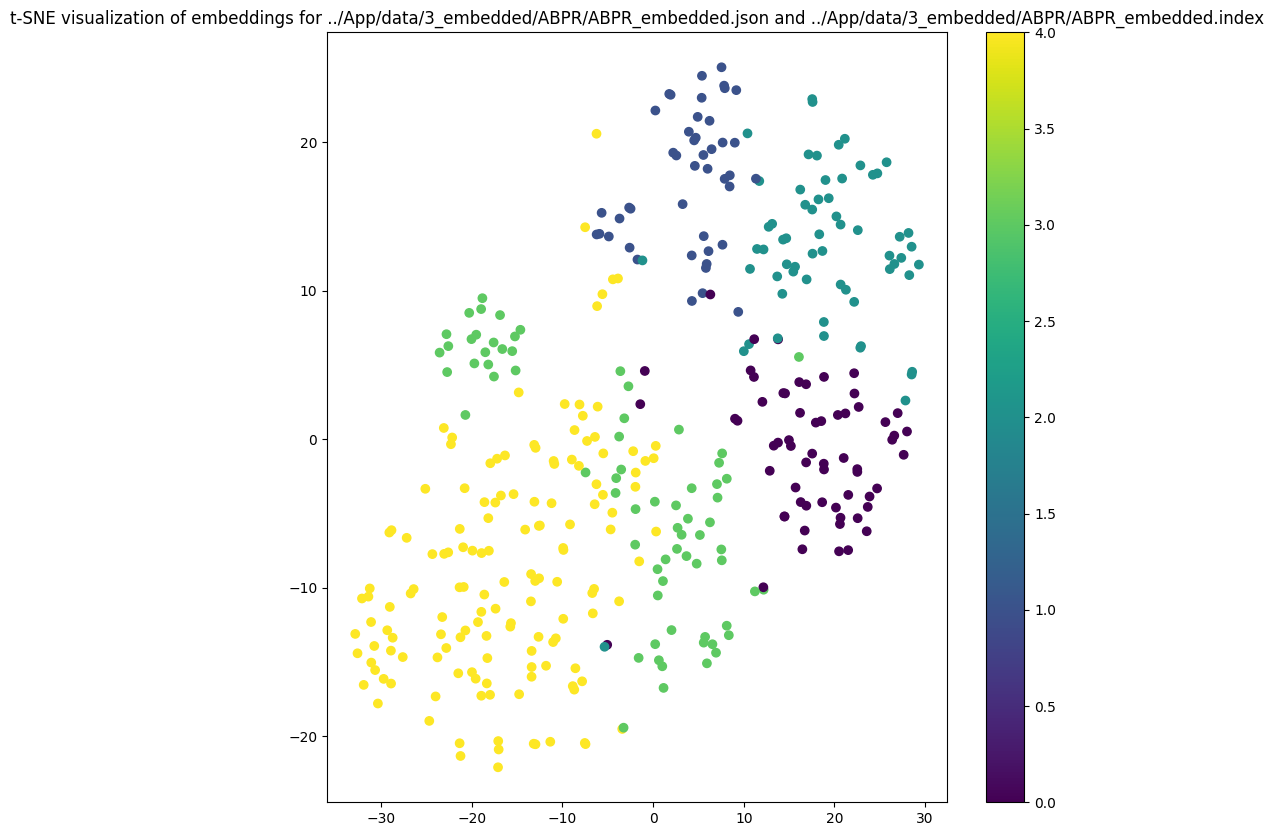

Article ID: 0, Distance: 0.0
Article ID: 132, Distance: 0.26170074939727783
Article ID: 1, Distance: 0.7119200229644775
Article ID: 61, Distance: 0.7457120418548584
Article ID: 2, Distance: 0.8071309328079224


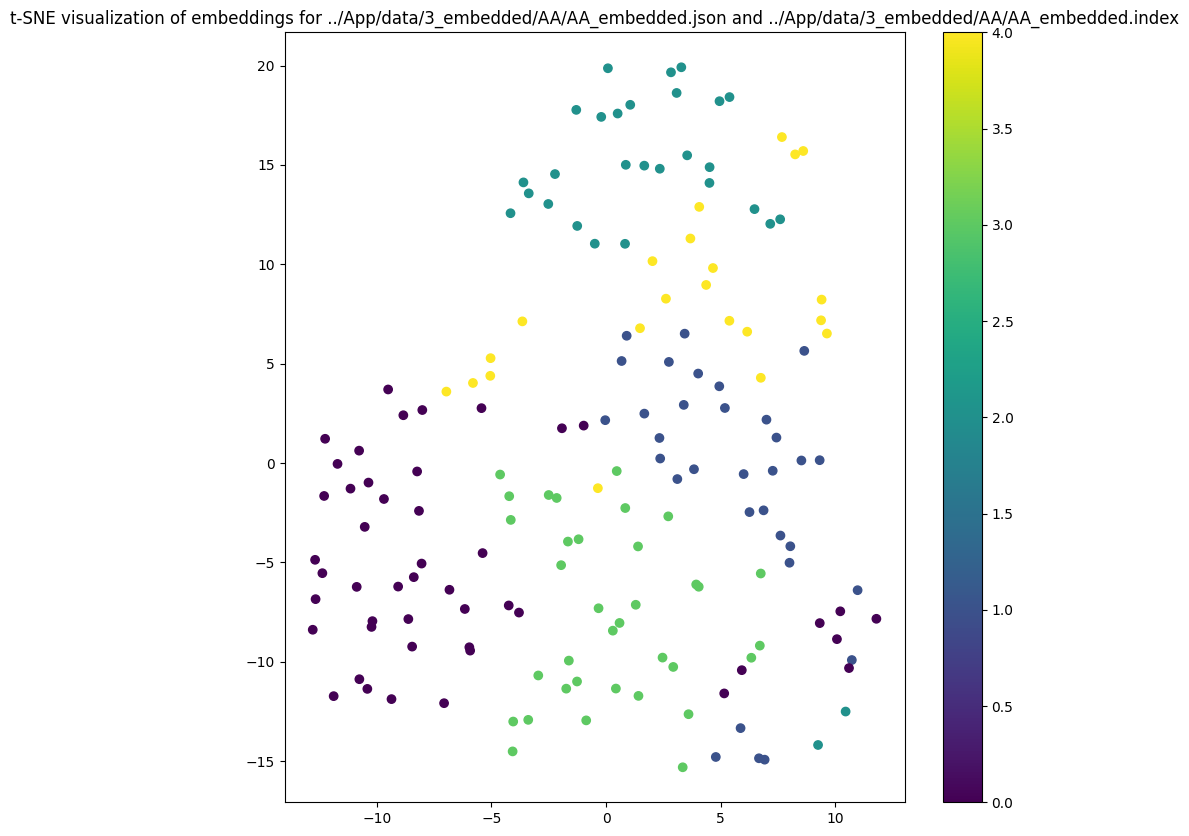

Article ID: 0, Distance: 0.0
Article ID: 2, Distance: 0.6270301342010498
Article ID: 184, Distance: 0.7485671639442444
Article ID: 1, Distance: 0.7878036499023438
Article ID: 196, Distance: 0.793679416179657


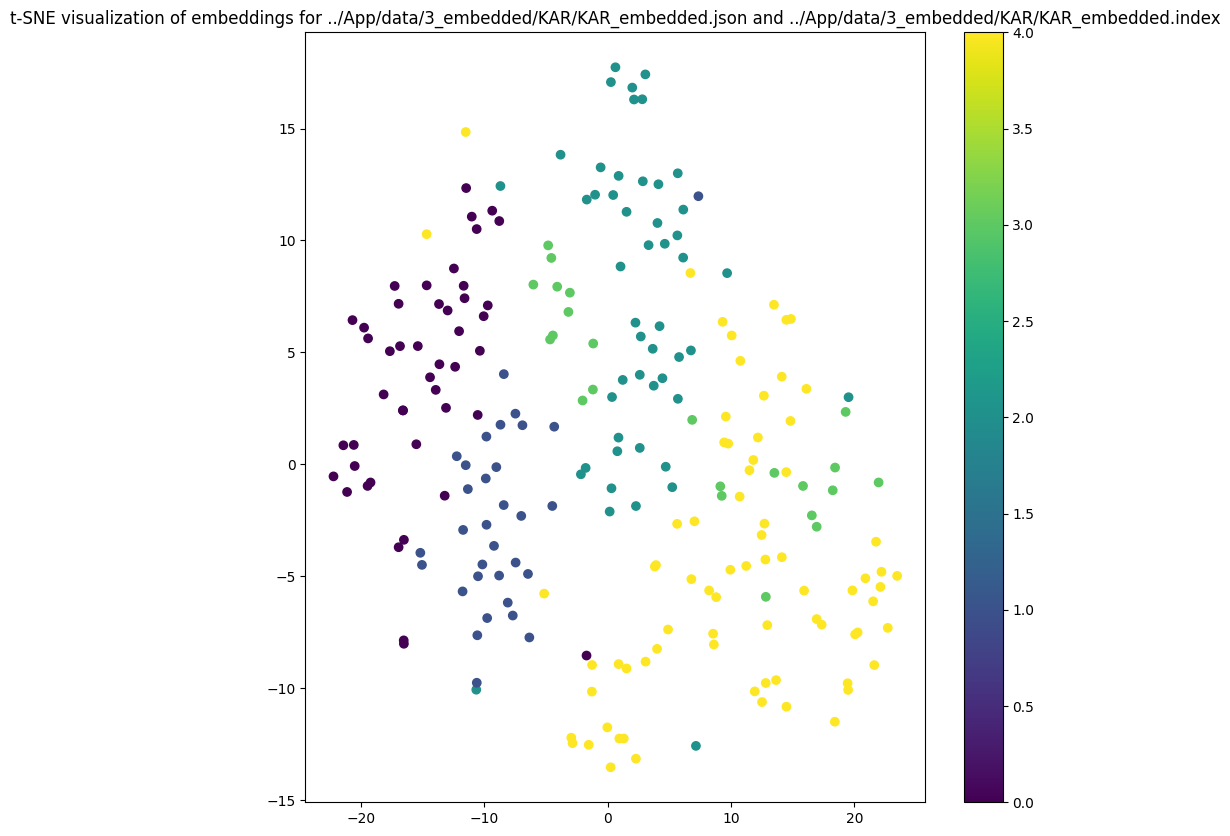

In [7]:
import numpy as np
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
import os

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def evaluate_model(json_files, index_files, name):
    if isinstance(json_files, str):
        json_files = [json_files]
    if isinstance(index_files, str):
        index_files = [index_files]

    for json_file, index_file in zip(json_files, index_files):
        # Check if the JSON file exists
        if not os.path.exists(json_file):
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")
        
        # Check if the FAISS index file exists
        if not os.path.exists(index_file):
            raise FileNotFoundError(f"FAISS index file '{index_file}' not found.")

        # Load JSON data
        data = load_json(json_file)
        
        # Load FAISS index
        index = faiss.read_index(index_file)
        embeddings = np.array([article['embedding'] for article in data])

        # Define a function to perform similarity search
        def similarity_search(query_embedding, k=5):
            D, I = index.search(np.array([query_embedding]), k)
            return I[0], D[0]

        # Evaluate with a few sample queries
        sample_query = data[0]['embedding']
        neighbors, distances = similarity_search(sample_query)
        for idx, distance in zip(neighbors, distances):
            print(f"Article ID: {idx}, Distance: {distance}")

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(embeddings)
        #print(similarity_matrix)
        # Clustering
        kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
        labels = kmeans.labels_

        # Visualize with t-SNE
        tsne = TSNE(n_components=2, random_state=0)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
        plt.colorbar()
        plt.title(f"t-SNE visualization of embeddings for {json_file} and {index_file}")
        plt.show()

# Provide the correct paths to your files
evaluate_model(
 ["../App/data/3_embedded/ABPR/ABPR_embedded.json", "../App/data/3_embedded/AA/AA_embedded.json", "../App/data/3_embedded/KAR/KAR_embedded.json"],
    ["../App/data/3_embedded/ABPR/ABPR_embedded.index", "../App/data/3_embedded/AA/AA_embedded.index", "../App/data/3_embedded/KAR/KAR_embedded.index"],
    ["ABPR", "AA", "KAR"],
)

# Evaluation of improved Query as 3d Model:


Originales Query: Was sind die Pausenregelungen?


improving query... 


improved query: Was sind die gesetzlich vorgeschriebenen Pausenregelungen für Arbeitnehmer am Stadtspital Zürich in der Schweiz?
Gibt es spezifische Pausenregelungen, die für Angestellte am Stadtspital Zürich gelten?
Wie werden Pausen am Stadtspital Zürich verwaltet und geregelt?
Welche Pausenregelungen müssen Arbeitnehmer am Stadtspital Zürich gemäß Arbeitsgesetz einhalten?

FAISS index dimensionality: 3072
Article ID: 259 PReg,  Distance: 0.5833419561386108 Allgemeines
Article ID: 217 AZRG,  Distance: 0.6117786169052124 Verpflegungspause
Article ID: 260 PReg,  Distance: 0.6267353892326355 Pausenregelung
Article ID: 170 ABPR,  Distance: 0.6606264114379883 Pausen
Article ID: 264 PReg,  Distance: 0.7653807401657104 Beispiele


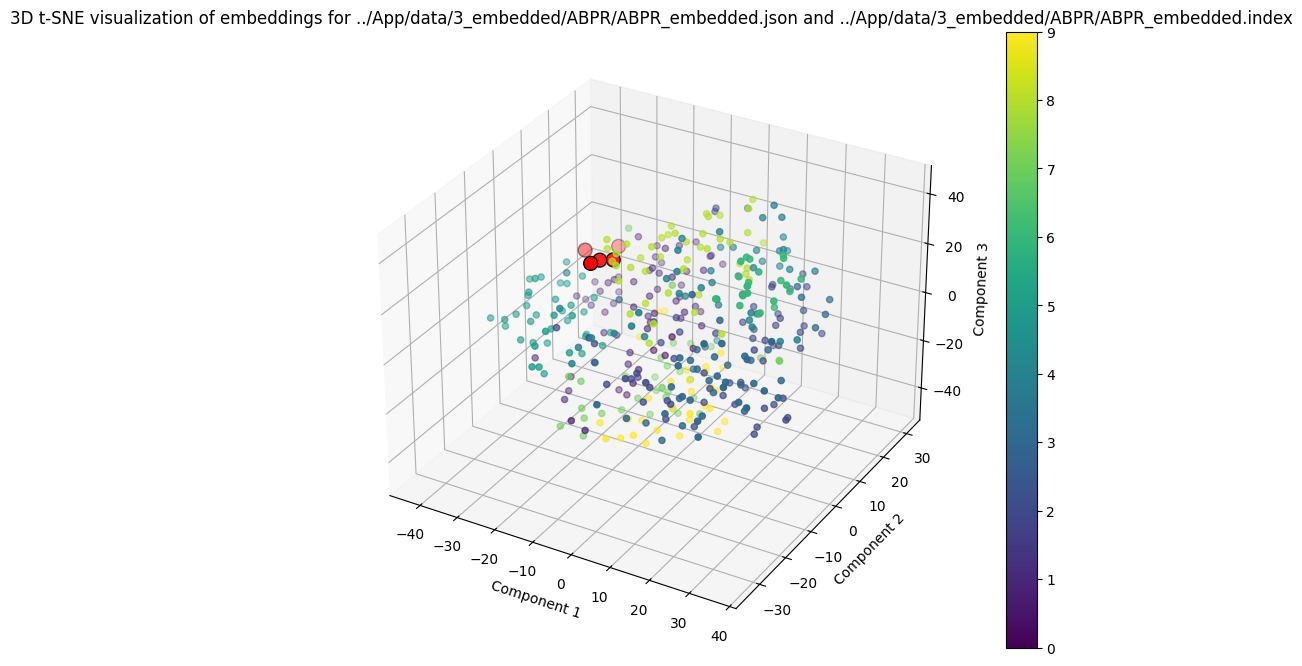

FAISS index dimensionality: 3072
Article ID: 22 AZRG,  Distance: 0.611614465713501 Verpflegungspause
Article ID: 134 AA_GSP,  Distance: 0.7532867193222046 Sachlicher Geltungsbereich
Article ID: 23 AZRG,  Distance: 0.7659735083580017 Kurzpause
Article ID: 144 AA_GSP,  Distance: 0.769719123840332 AA und OA i.V. ohne Facharzttitel
Article ID: 145 AA_GSP,  Distance: 0.7796312570571899 AA und OA i.V. mit Facharzttitel


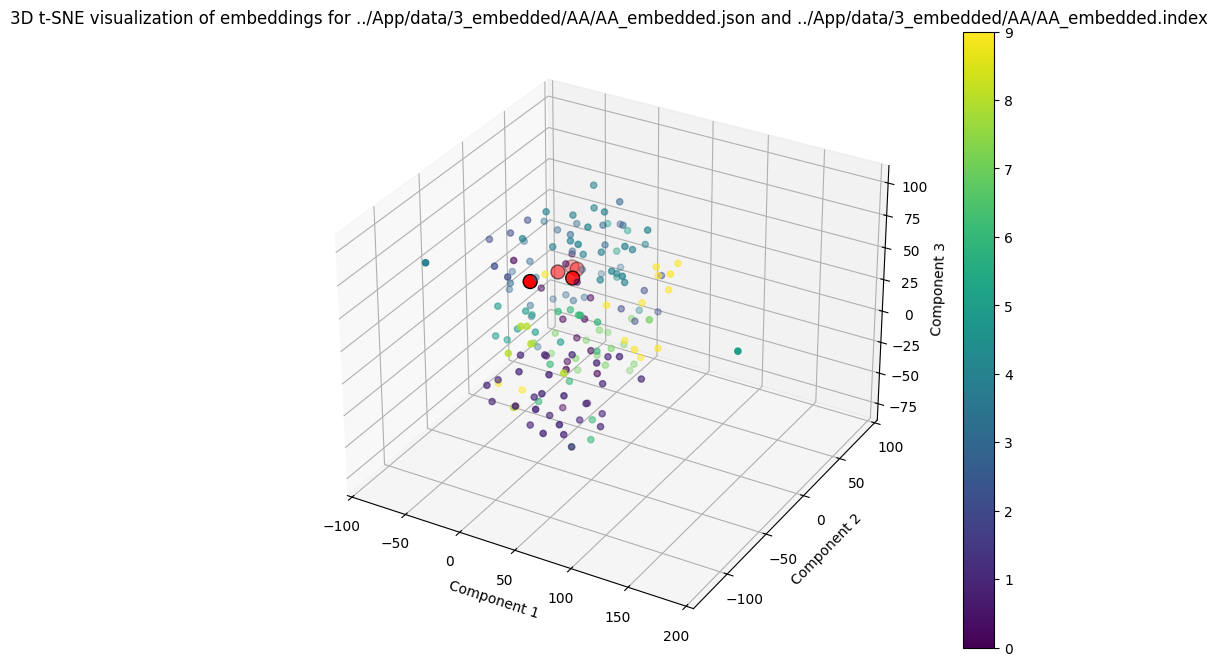

FAISS index dimensionality: 3072
Article ID: 220 PReg,  Distance: 0.5838319659233093 Allgemeines
Article ID: 221 PReg,  Distance: 0.6261369585990906 Pausenregelung
Article ID: 170 ABPR,  Distance: 0.6604934930801392 Pausen
Article ID: 225 PReg,  Distance: 0.764806866645813 Beispiele
Article ID: 169 ABPR,  Distance: 0.7844824194908142 Arbeitsfreie Tage (Ruhetage)


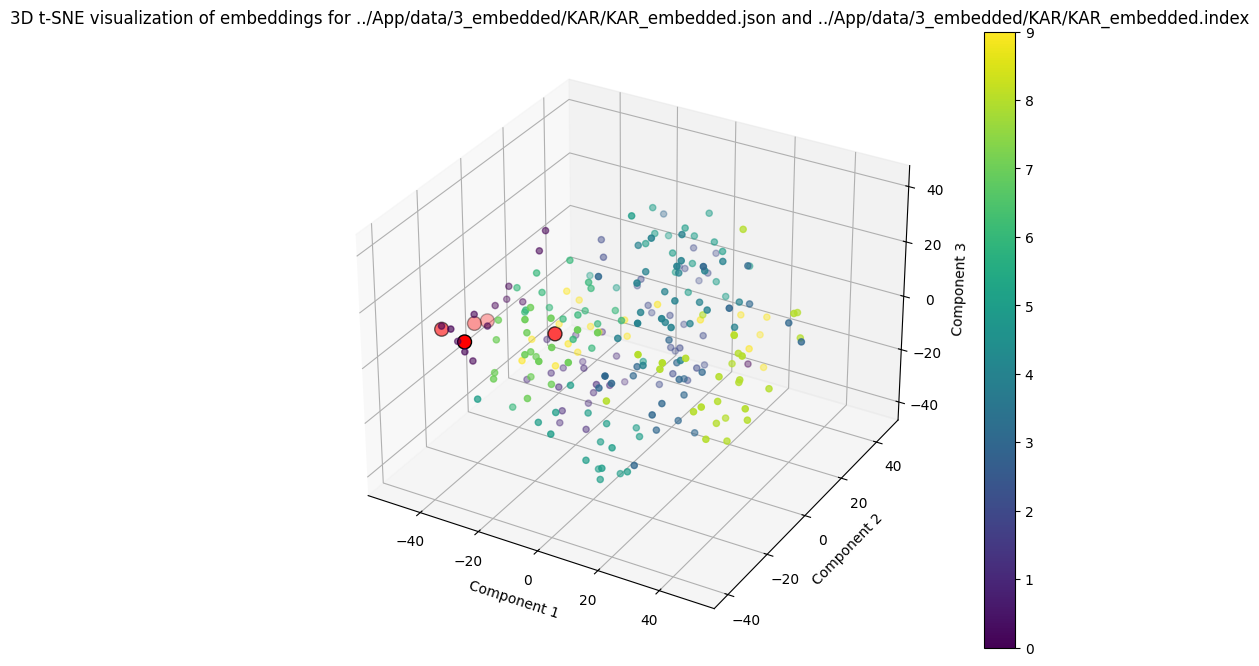

In [6]:
import numpy as np
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import openai
from openai import OpenAI
import os
from dotenv import load_dotenv

client = OpenAI()
load_dotenv()

client.api_key = os.getenv('OPENAI_API_KEY')

# Function to load JSON data from a file

model_large = "text-embedding-3-large"  
model_small = "text-embedding-3-small" 


def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def get_embedding_large(text, model=model_large):
    text = text.replace("\n", " ")
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

def get_embedding_small(text, model=model_small):
    text = text.replace("\n", " ")
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

def evaluate_models(json_files, index_files, names, models, query):
    if isinstance(json_files, str):
        json_files = [json_files]
    if isinstance(index_files, str):
        index_files = [index_files]
    if isinstance(names, str):
        names = [names]
    if isinstance(models, str):
        models = [models]

    for json_file, index_file, dataset_name, model in zip(json_files, index_files, names, models):
        # Check if the JSON file exists
        if not os.path.exists(json_file):
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")
        
        # Check if the FAISS index file exists
        if not os.path.exists(index_file):
            raise FileNotFoundError(f"FAISS index file '{index_file}' not found.")

        # Load JSON data
        data = load_json(json_file)
        
        # Load FAISS index
        index = faiss.read_index(index_file)
        embeddings = np.array([article['embedding'] for article in data])

        # Check the dimensionality of the FAISS index
        print(f"FAISS index dimensionality: {index.d}")

        # Convert query to embedding
        if model == "large":
            query_embedding = get_embedding_large(query)
        elif model == "small":
            query_embedding = get_embedding_small(query)
        else:
            raise ValueError("Invalid model type specified")
            

        # Define a function to perform similarity search
        def similarity_search(query_embedding, k=5):
            D, I = index.search(np.array([query_embedding]).astype('float32'), k)
            return I[0], D[0]

        # Perform similarity search with the query embedding
        neighbors, distances = similarity_search(query_embedding)
        closest_titles = [data[idx]['title'] for idx in neighbors]
        closest_Gesetzestext = [data[idx]['metadata']['Gesetzestext'] for idx in neighbors]
        for idx, distance, gesetzestext, title in zip(neighbors, distances, closest_Gesetzestext, closest_titles):
            print(f"Article ID: {idx} {gesetzestext},  Distance: {distance} {title}")

        
        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(embeddings)
        #print(similarity_matrix)

        # Clustering
        kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings)
        labels = kmeans.labels_

       
        # Visualize with 3D t-SNE
        tsne = TSNE(n_components=3, random_state=0)
        embeddings_3d = tsne.fit_transform(embeddings)



        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        sc = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap='viridis')

 # Highlight closest articles
        closest_points = embeddings_3d[neighbors]
        ax.scatter(closest_points[:, 0], closest_points[:, 1], c='red', edgecolors='k', s=100, label='Closest Articles')

        plt.colorbar(sc)
        ax.set_title(f"3D t-SNE visualization of embeddings for {json_file} and {index_file}")
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')

        plt.show()

query = "Was sind die Pausenregelungen?"


def refine_query(query):
    print("\nOriginales Query: " + query + "\n")
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": f"Erweitere die User Frage: <anfrage>{query}</anfrage>, mit Suchbegriffen, damit die Frage möglichst gute RAG ergebnisse liefert. Der erweiterte Anfrage soll ich immer auf den Kontext einer Anstellung am Stadtspital Zürich in der Schweiz beziehen. Alle Antworten sollen als Fragen formuliert sein"},
        ]
    )
    response = response.choices[0].message.content
    print("\nimproving query... \n")
    print("\nimproved query: " + response + "\n")
    return response
# Provide the correct paths to your files

query = refine_query(query)

"""
evaluate_models(
    ["APP/data/JSON/articles_main_embedded.json"],
    ["APP/data/JSON/articles_main.index"],
    ["Main"],
    ["large"],
    query
)
"""
evaluate_models(
  ["../App/data/3_embedded/ABPR/ABPR_embedded.json", "../App/data/3_embedded/AA/AA_embedded.json", "../App/data/3_embedded/KAR/KAR_embedded.json"],
    ["../App/data/3_embedded/ABPR/ABPR_embedded.index", "../App/data/3_embedded/AA/AA_embedded.index", "../App/data/3_embedded/KAR/KAR_embedded.index"],
    ["ABPR", "AA", "KAR"],
    ["large", "large", "large",],
    query

)


# Evaluation of distribution of embeddings as histogram

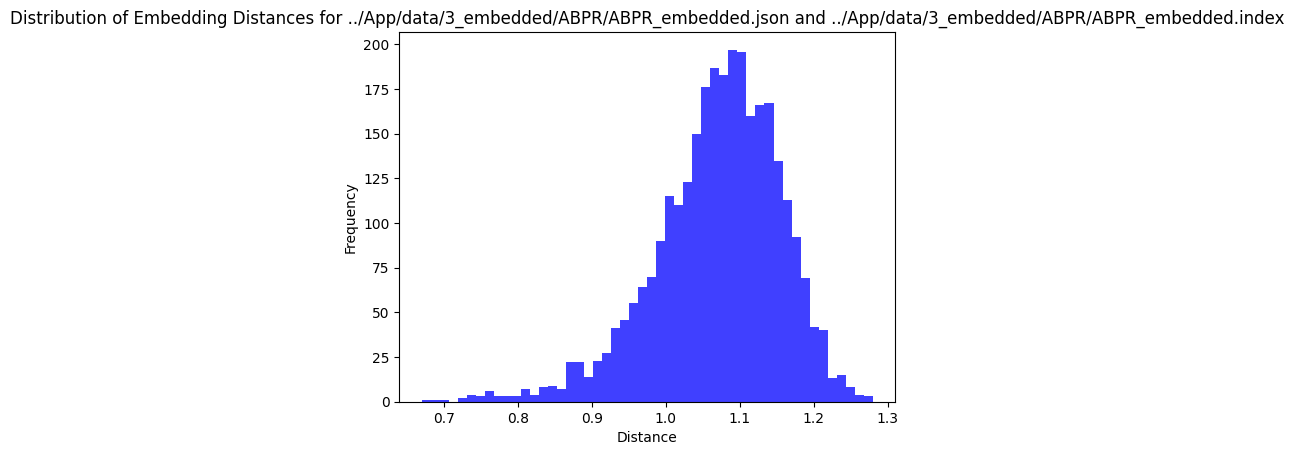

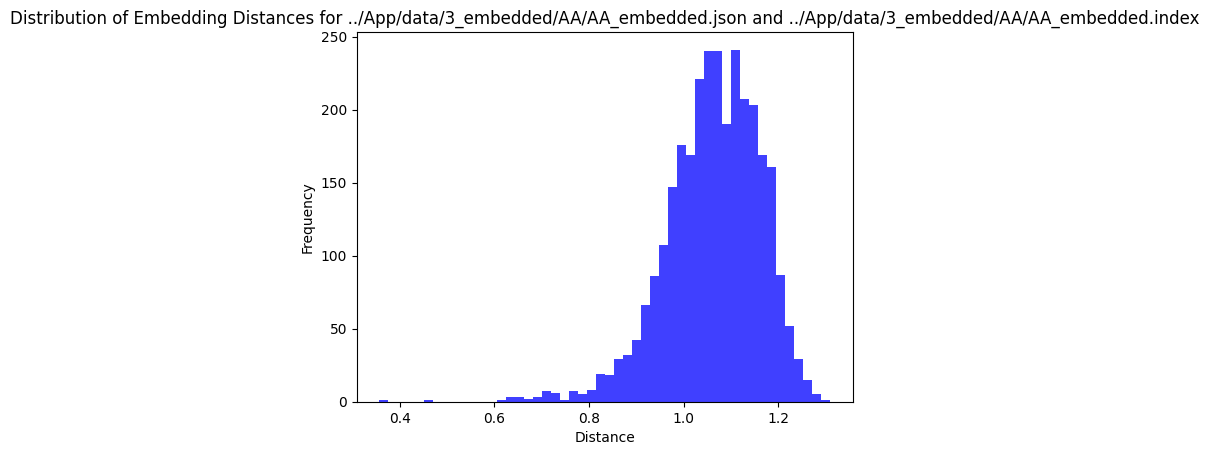

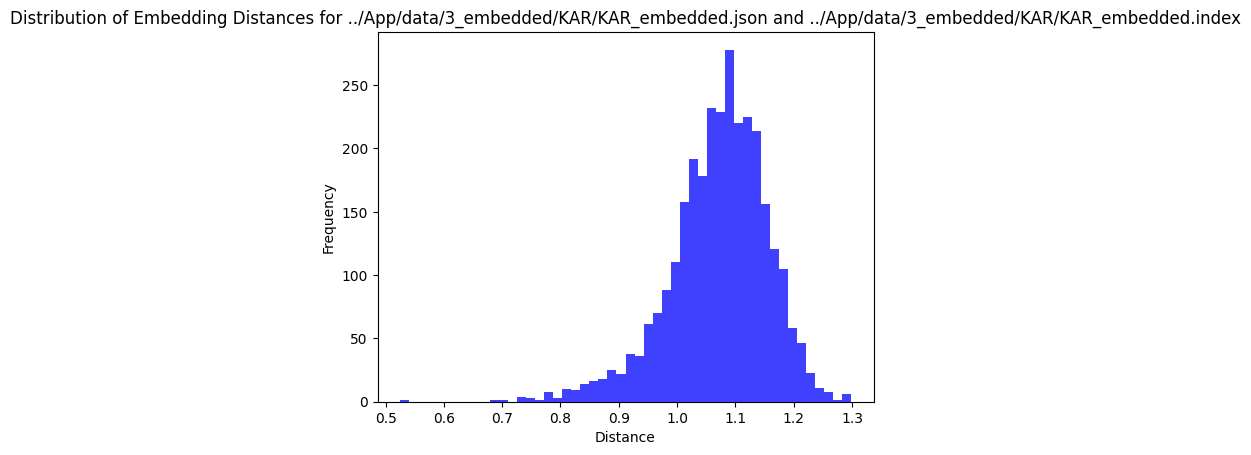

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import json
import os

# Function to load JSON data from a file
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def evaluate_distance_distribution(json_files, index_files, sample_size=3000):
    if isinstance(json_files, str):
        json_files = [json_files]
    if isinstance(index_files, str):
        index_files = [index_files]

    for json_file, index_file in zip(json_files, index_files):
        # Check if the JSON file exists
        if not os.path.exists(json_file):
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")
        
        # Check if the FAISS index file exists
        if not os.path.exists(index_file):
            raise FileNotFoundError(f"FAISS index file '{index_file}' not found.")

        # Load JSON data
        data = load_json(json_file)
        
        # Load FAISS index
        index = faiss.read_index(index_file)
        embeddings = np.array([article['embedding'] for article in data])

        # Calculate distances between a sample of pairs
        distances = []

        for _ in range(sample_size):
            idx1, idx2 = np.random.choice(len(embeddings), 2, replace=False)
            distance = np.linalg.norm(embeddings[idx1] - embeddings[idx2])
            distances.append(distance)

        # Plot the distribution of distances
        plt.hist(distances, bins=50, alpha=0.75, color='blue')
        plt.title(f"Distribution of Embedding Distances for {json_file} and {index_file}")
        plt.xlabel("Distance")
        plt.ylabel("Frequency")
        plt.show()

# Provide the correct paths to your files
evaluate_distance_distribution(
    ["../App/data/3_embedded/ABPR/ABPR_embedded.json", "../App/data/3_embedded/AA/AA_embedded.json", "../App/data/3_embedded/KAR/KAR_embedded.json"],
    ["../App/data/3_embedded/ABPR/ABPR_embedded.index", "../App/data/3_embedded/AA/AA_embedded.index", "../App/data/3_embedded/KAR/KAR_embedded.index"],

    )


# Evaluation of individual, actual RAG return given a specific embedding

In [10]:
import openai
import numpy as np
import faiss
import json

def get_embedding(text, tags=[], model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    combine = text + " " .join(tags)
    return openai.embeddings.create(input=[combine], model=model).data[0].embedding


# Function to load JSON data from a file
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Load your articles data
file_path = '../App/data/3_embedded/ABPR/ABPR_embedded.json'
model_type = '../App/data/3_embedded/ABPR/ABPR_embedded.index'

data = load_json(file_path)

# Load your FAISS index
index = faiss.read_index(model_type)

# Define a function to perform similarity search
def similarity_search(query_embedding, k=5):
    D, I = index.search(np.array([query_embedding]), k)
    return I[0], D[0]

# Example query
query_text = "Wann habe ich Mutterschaftsurlaub?"
query_tags = ["tag1", "tag2"]  # Replace with relevant tags

# Generate embedding for the query
query_embedding = get_embedding(query_text, query_tags)

# Perform similarity search
neighbors, distances = similarity_search(query_embedding)

# Display the results
print("Query:", query_text)
for idx, distance in zip(neighbors, distances):
    article = data[idx]
    print(f"\nArtikel: {article['article_number']} {article['metadata']['Gesetzestext']}")
    print(f"Title: {article['title']}")
    print(f"Distance: {distance}")
    print(f"Title: {article['title']}")
    print(f"Text: {article['text']}")



Query: Wann habe ich Mutterschaftsurlaub?

Artikel: Art. 121 ABPR
Title: Anspruch auf Mutterschaftsurlaub
Distance: 0.6624552011489868
Title: Anspruch auf Mutterschaftsurlaub
Text: 1. Die Angestellte hat Anspruch auf einen bezahlten Mutterschaftsurlaub von insgesamt 16 Kalenderwochen, den sie frühestens zwei Wochen vor dem ärztlich bestimmten Geburtstermin antreten kann.
2. Ohne ärztliches Zeugnis werden Abwesenheiten von der Arbeit in den letzten zwei Wochen vor der Geburt auf den bezahlten Mutterschaftsurlaub angerechnet.
3. Muss die Angestellte ihre Tätigkeit wegen schwangerschaftsbedingter Beschwerden früher als zwei Wochen vor der Geburt niederlegen, besteht Lohnanspruch, wenn ein ärztliches Zeugnis vorgelegt wird.
4. Nach dem Mutterschaftsurlaub kann der Beschäftigungsgrad auf Gesuch der Angestellten unter Wahrung des Urlaubsanspruches reduziert werden, so weit die dienstlichen Verhältnisse es zulassen.
5. Im Rahmen der betrieblichen Möglichkeiten wird weiterer unbezahlter Urlaub

# Evaluation of individual, actual RAG return using an LM imporved query given a specific embedding

In [39]:
import openai
import numpy as np
import faiss
import json
from openai import OpenAI

load_dotenv()
client = OpenAI()
client.api_key = os.getenv('OPENAI_API_KEY')

def get_embedding(text, tags=[], model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    combine = text + " " .join(tags)
    return openai.embeddings.create(input=[combine], model=model).data[0].embedding


# Function to load JSON data from a file
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Load your articles data
file_path = 'App/data/JSON/articles_main.json'
model_type = 'App/data/JSON/articles_main.index'
data = load_json(file_path)

# Load your FAISS index
index = faiss.read_index(model_type)

# Define a function to perform similarity search
def similarity_search(query_embedding, k=5):
    D, I = index.search(np.array([query_embedding]), k)
    return I[0], D[0]

# Example query
query_text = "Wann habe ich Mutterschaftsurlaub?"


def refine_query(query):
    print("\nOriginales Query: " + query + "\n")
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": f"Erweitere die User Frage: <anfrage>{query}</anfrage>, mit Suchbegriffen, damit die Frage möglichst gute RAG ergebnisse liefert. Der erweiterte Anfrage soll ich immer auf den Kontext einer Anstellung am Stadtspital Zürich in der Schweiz beziehen. Alle Antworten sollen als Fragen formuliert sein"},
        ]
    )
    response = response.choices[0].message.content
    print("\nimproving query... \n")
    print("\nimproved query: " + response + "\n")
    return response


query_text = refine_query(query_text)


query_tags = ["tag1", "tag2"]  # Replace with relevant tags

# Generate embedding for the query
query_embedding = get_embedding(query_text, query_tags)

# Perform similarity search
neighbors, distances = similarity_search(query_embedding)

# Display the results
#print("Query:", query_text)
for idx, distance in zip(neighbors, distances):
    article = data[idx]
    print(f"\nArtikel: {article['article_number']} {article['metadata']['Gesetzestext']}")
    print(f"Title: {article['title']}")
    print(f"Distance: {distance}")
    print(f"Title: {article['title']}")
    print(f"Text: {article['text']}")




Originales Query: Wann habe ich Mutterschaftsurlaub?


improving query... 


improved query: Wann beginnt der Mutterschaftsurlaub am Stadtspital Zürich?

Wie lange dauert der Mutterschaftsurlaub für Angestellte des Stadtspitals Zürich?

Welche Voraussetzungen gelten für den Mutterschaftsurlaub am Stadtspital Zürich?

Welche Leistungen sind im Mutterschaftsurlaub am Stadtspital Zürich enthalten?

Gibt es Möglichkeiten zur Verlängerung des Mutterschaftsurlaubs am Stadtspital Zürich?

Wie wirkt sich Mutterschaftsurlaub auf meinen Arbeitsvertrag am Stadtspital Zürich aus?

Kann ich meinen Mutterschaftsurlaub am Stadtspital Zürich flexibel gestalten?


Artikel: Art. 121 ABPR
Title: Anspruch auf Mutterschaftsurlaub
Distance: 0.6446361541748047
Title: Anspruch auf Mutterschaftsurlaub
Text: 1. Die Angestellte hat Anspruch auf einen bezahlten Mutterschaftsurlaub von insgesamt 16 Kalenderwochen, den sie frühestens zwei Wochen vor dem ärztlich bestimmten Geburtstermin antreten kann.
2. Ohne ärzt

FAISS index dimensionality: 3072
Article ID: 260 PReg,  Distance: 0.7404969930648804 Pausenregelung
Article ID: 218 AZRG,  Distance: 0.7827295660972595 Kurzpause
Article ID: 170 ABPR,  Distance: 0.787030816078186 Pausen
Article ID: 261 PReg,  Distance: 0.8256785869598389 Verfügbarkeit während der Pause
Article ID: 217 AZRG,  Distance: 0.8298000693321228 Verpflegungspause


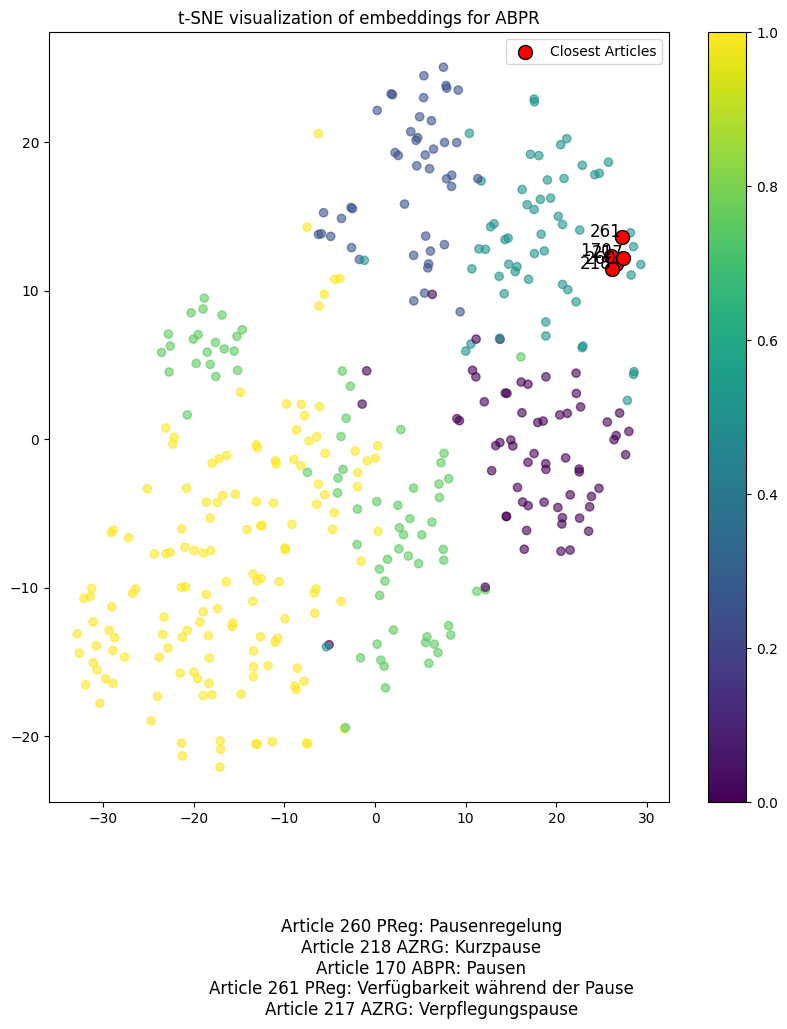

FAISS index dimensionality: 3072
Article ID: 77 ARG,  Distance: 0.7590382099151611 Pausen
Article ID: 145 AA_GSP,  Distance: 0.7733391523361206 AA und OA i.V. mit Facharzttitel
Article ID: 23 AZRG,  Distance: 0.7834105491638184 Kurzpause
Article ID: 146 AA_GSP,  Distance: 0.7893154621124268 Konditionen zum Pausenbezug
Article ID: 22 AZRG,  Distance: 0.8389028310775757 Verpflegungspause


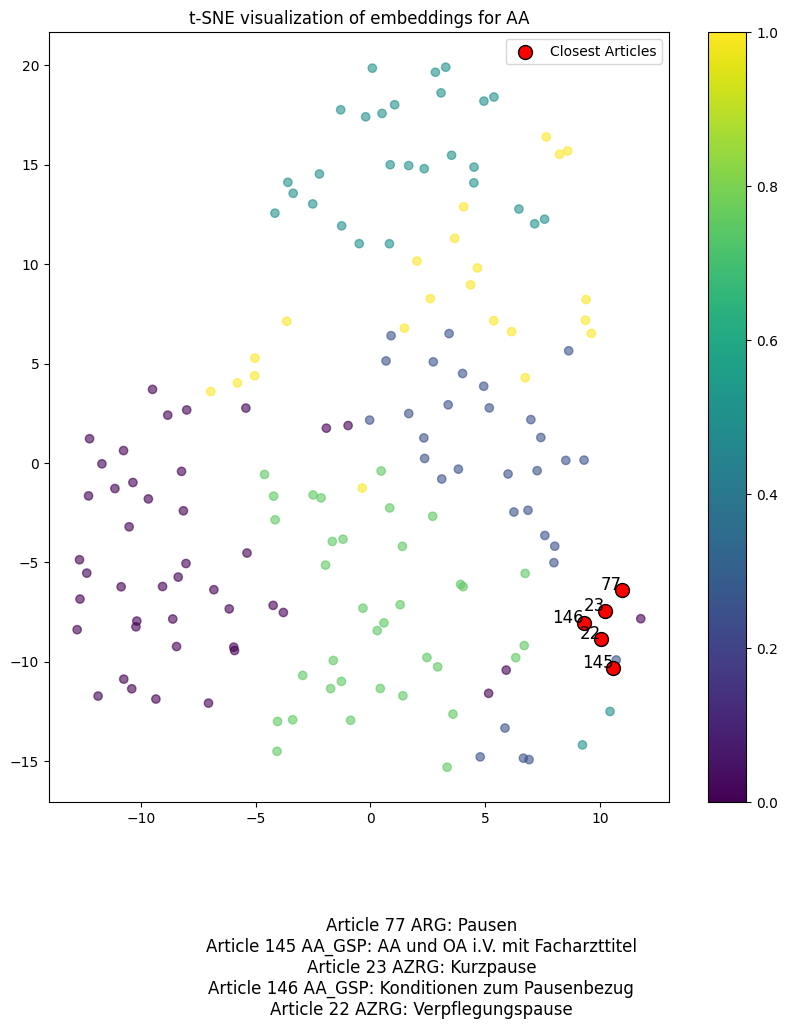

FAISS index dimensionality: 3072
Article ID: 221 PReg,  Distance: 0.7406293749809265 Pausenregelung
Article ID: 170 ABPR,  Distance: 0.7870646119117737 Pausen
Article ID: 222 PReg,  Distance: 0.8248306512832642 Verfügbarkeit während der Pause
Article ID: 225 PReg,  Distance: 0.8375061750411987 Beispiele
Article ID: 220 PReg,  Distance: 0.8702603578567505 Allgemeines


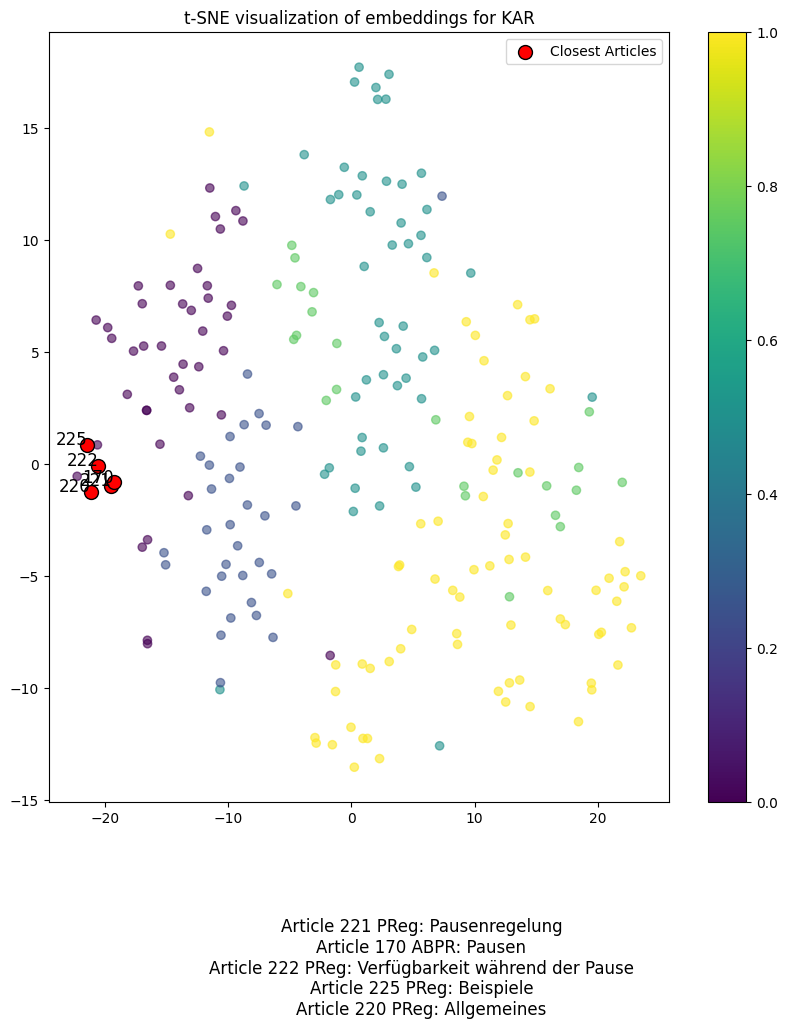

In [11]:
import json
import numpy as np
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import openai
import os
from dotenv import load_dotenv
from openai import OpenAI

# Configure OpenAI API key
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

# Load Models
model_large = "text-embedding-3-large"  
model_small = "text-embedding-3-small" 

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def get_embedding_large(text, model=model_large):
    text = text.replace("\n", " ")
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

def get_embedding_small(text, model=model_small):
    text = text.replace("\n", " ")
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

def evaluate_model(json_files, index_files, names, models, query):
    if isinstance(json_files, str):
        json_files = [json_files]
    if isinstance(index_files, str):
        index_files = [index_files]
    if isinstance(names, str):
        names = [names]
    if isinstance(models, str):
        models = [models]

    for json_file, index_file, dataset_name, model in zip(json_files, index_files, names, models):
        # Check if the JSON file exists
        if not os.path.exists(json_file):
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")
         
        # Check if the FAISS index file exists
        if not os.path.exists(index_file):
            raise FileNotFoundError(f"FAISS index file'{index_file}' not found.")

        # Load JSON data
        data = load_json(json_file)
        
        # Load FAISS index
        index = faiss.read_index(index_file)
        embeddings = np.array([article['embedding'] for article in data])

        # Check the dimensionality of the FAISS index
        print(f"FAISS index dimensionality: {index.d}")

        # Convert query to embedding
        if model == "large":
            query_embedding = get_embedding_large(query)
        elif model == "small":
            query_embedding = get_embedding_small(query)
        else:
            raise ValueError("Invalid model type specified")
            

        # Define a function to perform similarity search
        def similarity_search(query_embedding, k=5):
            D, I = index.search(np.array([query_embedding]).astype('float32'), k)
            return I[0], D[0]

        # Perform similarity search with the query embedding
        neighbors, distances = similarity_search(query_embedding)
        closest_titles = [data[idx]['title'] for idx in neighbors]
        closest_Gesetzestext = [data[idx]['metadata']['Gesetzestext'] for idx in neighbors]
        for idx, distance, gesetzestext, title in zip(neighbors, distances, closest_Gesetzestext, closest_titles):
            print(f"Article ID: {idx} {gesetzestext},  Distance: {distance} {title}")

        

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(embeddings)

        # Clustering
        kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
        labels = kmeans.labels_

        # Visualize with t-SNE
        tsne = TSNE(n_components=2, random_state=0)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)

        # Highlight closest articles
        closest_points = embeddings_2d[neighbors]
        plt.scatter(closest_points[:, 0], closest_points[:, 1], c='red', edgecolors='k', s=100, label='Closest Articles')
        
        # Add article numbers
        for i, (x, y) in enumerate(closest_points):
            plt.text(x, y, str(neighbors[i]), fontsize=12, ha='right')

        plt.colorbar()
        plt.title(f"t-SNE visualization of embeddings for {dataset_name}")
        plt.legend()
        
        # Display list of closest articles at the bottom
        plt.figtext(0.5, -0.1, "\n".join([f"Article {idx} {gesetzestext}: {title} " for idx, title, gesetzestext in zip(neighbors, closest_titles, closest_Gesetzestext)]), 
                    wrap=True, horizontalalignment='center', fontsize=12)

        plt.show()

query = "Was sind die Pausenregelungen?"

evaluate_model(
    ["../App/data/3_embedded/ABPR/ABPR_embedded.json", "../App/data/3_embedded/AA/AA_embedded.json", "../App/data/3_embedded/KAR/KAR_embedded.json"],
    ["../App/data/3_embedded/ABPR/ABPR_embedded.index", "../App/data/3_embedded/AA/AA_embedded.index", "../App/data/3_embedded/KAR/KAR_embedded.index"],
    ["ABPR", "AA", "KAR"],
    ["large", "large", "large",],
    query
)



Originales Query: Was sind die Pausenregelungen?


improving query... 


improved query: Welche Regeln gelten am Stadtspital Zürich in der Schweiz bezüglich der Pausen während der Arbeitszeit?
Welche gesetzlichen Vorgaben gibt es am Stadtspital Zürich in der Schweiz bezüglich der Pausenregelungen?
Was sind die betrieblichen Richtlinien am Stadtspital Zürich in der Schweiz bezüglich Pausen während der Arbeitszeit?
Gibt es spezielle Bestimmungen am Stadtspital Zürich in der Schweiz in Bezug auf die Dauer und Häufigkeit von Pausen?

FAISS index dimensionality: 3072
Article ID: 260 PReg,  Distance: 0.601954996585846 Pausenregelung
Article ID: 259 PReg,  Distance: 0.6021122932434082 Allgemeines
Article ID: 217 AZRG,  Distance: 0.60746169090271 Verpflegungspause
Article ID: 170 ABPR,  Distance: 0.6171272993087769 Pausen
Article ID: 218 AZRG,  Distance: 0.7228108644485474 Kurzpause


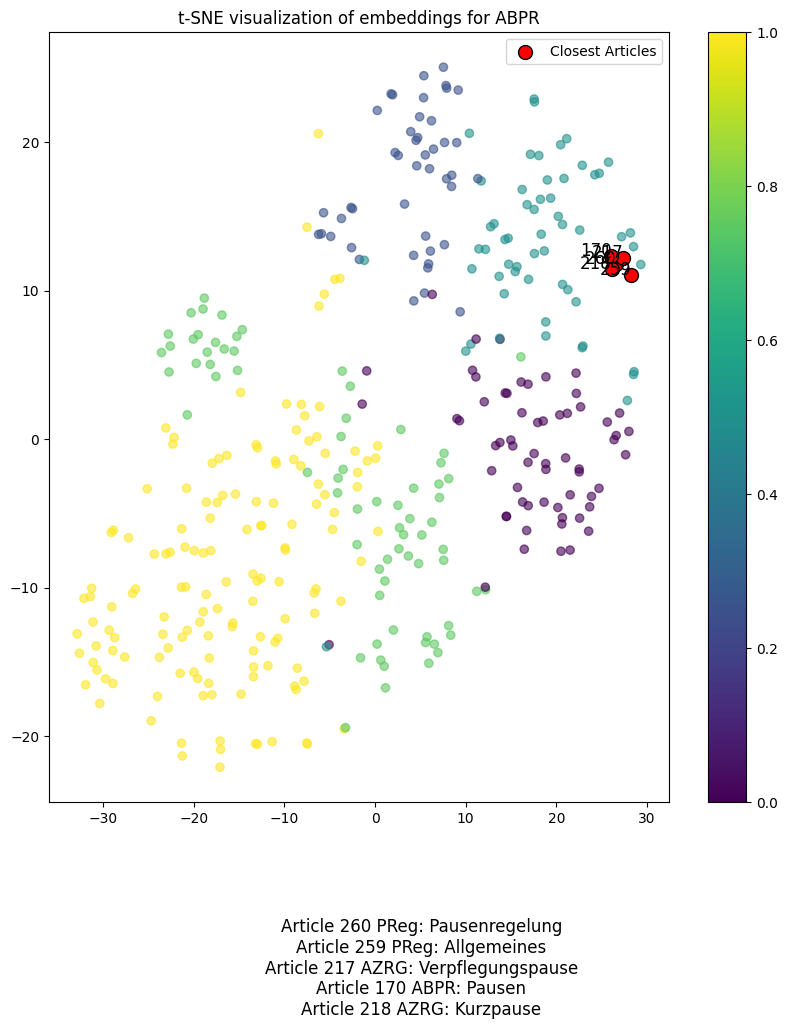

FAISS index dimensionality: 3072
Article ID: 22 AZRG,  Distance: 0.6084227561950684 Verpflegungspause
Article ID: 23 AZRG,  Distance: 0.7235275506973267 Kurzpause
Article ID: 134 AA_GSP,  Distance: 0.7530432939529419 Sachlicher Geltungsbereich
Article ID: 144 AA_GSP,  Distance: 0.7653528451919556 AA und OA i.V. ohne Facharzttitel
Article ID: 145 AA_GSP,  Distance: 0.7660170197486877 AA und OA i.V. mit Facharzttitel


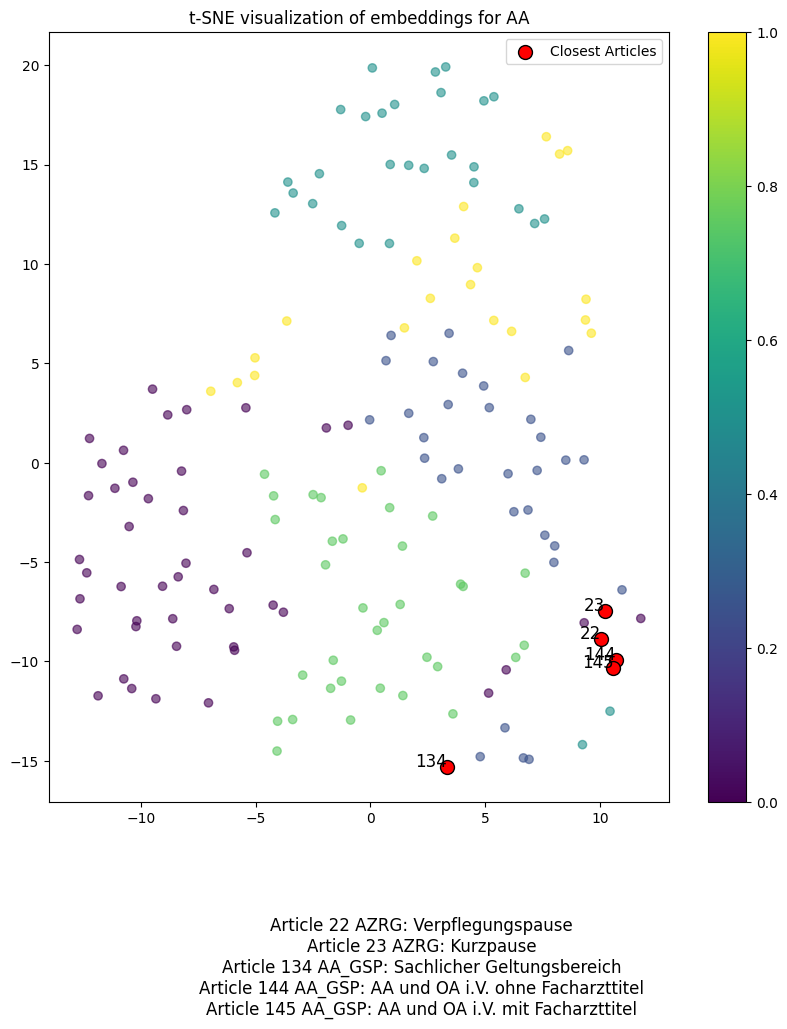

FAISS index dimensionality: 3072
Article ID: 220 PReg,  Distance: 0.6039903163909912 Allgemeines
Article ID: 221 PReg,  Distance: 0.6042116284370422 Pausenregelung
Article ID: 170 ABPR,  Distance: 0.6201550364494324 Pausen
Article ID: 225 PReg,  Distance: 0.7466652393341064 Beispiele
Article ID: 224 PReg,  Distance: 0.792183518409729 Festlegung der bezahlten Pausen


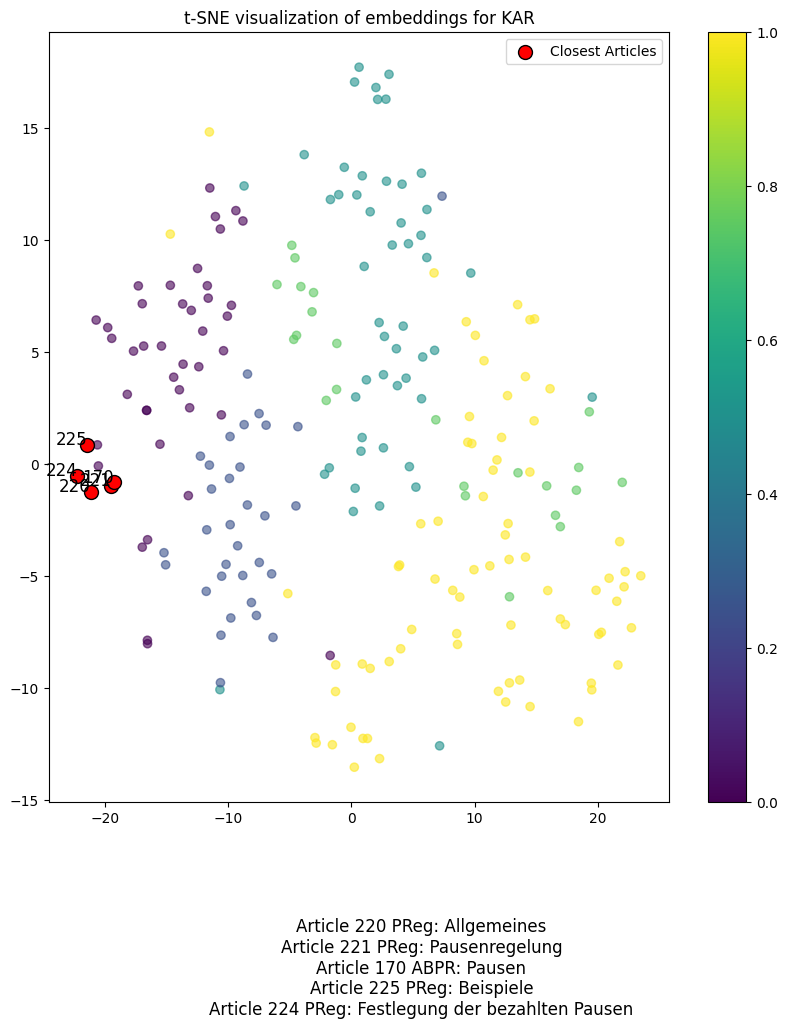

In [12]:
import json
import numpy as np
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import openai
import os
from dotenv import load_dotenv

# Configure OpenAI API key
load_dotenv()
client = OpenAI()
client.api_key= os.getenv('OPENAI_API_KEY')

 

# Load Models
model_large = "text-embedding-3-large"  
model_small = "text-embedding-3-small" 

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def get_embedding_large(text, model=model_large):
    text = text.replace("\n", " ")
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

def get_embedding_small(text, model=model_small):
    text = text.replace("\n", " ")
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

def evaluate_model(json_files, index_files, names, models, query):
    if isinstance(json_files, str):
        json_files = [json_files]
    if isinstance(index_files, str):
        index_files = [index_files]
    if isinstance(names, str):
        names = [names]
    if isinstance(models, str):
        models = [models]

    for json_file, index_file, dataset_name, model in zip(json_files, index_files, names, models):
        # Check if the JSON file exists
        if not os.path.exists(json_file):
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")
         
        # Check if the FAISS index file exists
        if not os.path.exists(index_file):
            raise FileNotFoundError(f"FAISS index file'{index_file}' not found.")

        # Load JSON data
        data = load_json(json_file)
        
        # Load FAISS index
        index = faiss.read_index(index_file)
        embeddings = np.array([article['embedding'] for article in data])

        # Check the dimensionality of the FAISS index
        print(f"FAISS index dimensionality: {index.d}")

        # Convert query to embedding
        if model == "large":
            query_embedding = get_embedding_large(query)
        elif model == "small":
            query_embedding = get_embedding_small(query)
        else:
            raise ValueError("Invalid model type specified")
            

        # Define a function to perform similarity search
        def similarity_search(query_embedding, k=5):
            D, I = index.search(np.array([query_embedding]).astype('float32'), k)
            return I[0], D[0]

        # Perform similarity search with the query embedding
        neighbors, distances = similarity_search(query_embedding)
        closest_titles = [data[idx]['title'] for idx in neighbors]
        closest_Gesetzestext = [data[idx]['metadata']['Gesetzestext'] for idx in neighbors]
        for idx, distance, gesetzestext, title in zip(neighbors, distances, closest_Gesetzestext, closest_titles):
            print(f"Article ID: {idx} {gesetzestext},  Distance: {distance} {title}")

        

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(embeddings)

        # Clustering
        kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
        labels = kmeans.labels_

        # Visualize with t-SNE
        tsne = TSNE(n_components=2, random_state=0)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)

        # Highlight closest articles
        closest_points = embeddings_2d[neighbors]
        plt.scatter(closest_points[:, 0], closest_points[:, 1], c='red', edgecolors='k', s=100, label='Closest Articles')
        
        # Add article numbers
        for i, (x, y) in enumerate(closest_points):
            plt.text(x, y, str(neighbors[i]), fontsize=12, ha='right')

        plt.colorbar()
        plt.title(f"t-SNE visualization of embeddings for {dataset_name}")
        plt.legend()
        
        # Display list of closest articles at the bottom
        plt.figtext(0.5, -0.1, "\n".join([f"Article {idx} {gesetzestext}: {title} " for idx, title, gesetzestext in zip(neighbors, closest_titles, closest_Gesetzestext)]), 
                    wrap=True, horizontalalignment='center', fontsize=12)

        plt.show()

query = "Was sind die Pausenregelungen?"


def refine_query(query):
    print("\nOriginales Query: " + query + "\n")
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": f"Erweitere die User Frage: <anfrage>{query}</anfrage>, mit Suchbegriffen, damit die Frage möglichst gute RAG ergebnisse liefert. Der erweiterte Anfrage soll ich immer auf den Kontext einer Anstellung am Stadtspital Zürich in der Schweiz beziehen. Alle Antworten sollen als Fragen formuliert sein"},
        ]
    )
    response = response.choices[0].message.content
    print("\nimproving query... \n")
    print("\nimproved query: " + response + "\n")
    return response


query = refine_query(query)


evaluate_model(
  ["../App/data/3_embedded/ABPR/ABPR_embedded.json", "../App/data/3_embedded/AA/AA_embedded.json", "../App/data/3_embedded/KAR/KAR_embedded.json"],
    ["../App/data/3_embedded/ABPR/ABPR_embedded.index", "../App/data/3_embedded/AA/AA_embedded.index", "../App/data/3_embedded/KAR/KAR_embedded.index"],
    ["ABPR", "AA", "KAR"],
    ["large", "large", "large",],
    query
)


# Evaluation of the direct PDF Aproach

e:\VS_Code\ZHAW\ML2\ML2_Project\RAG_CHATBOT\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Query embedding shape: (1, 384)
Embeddings shape: (424, 384)


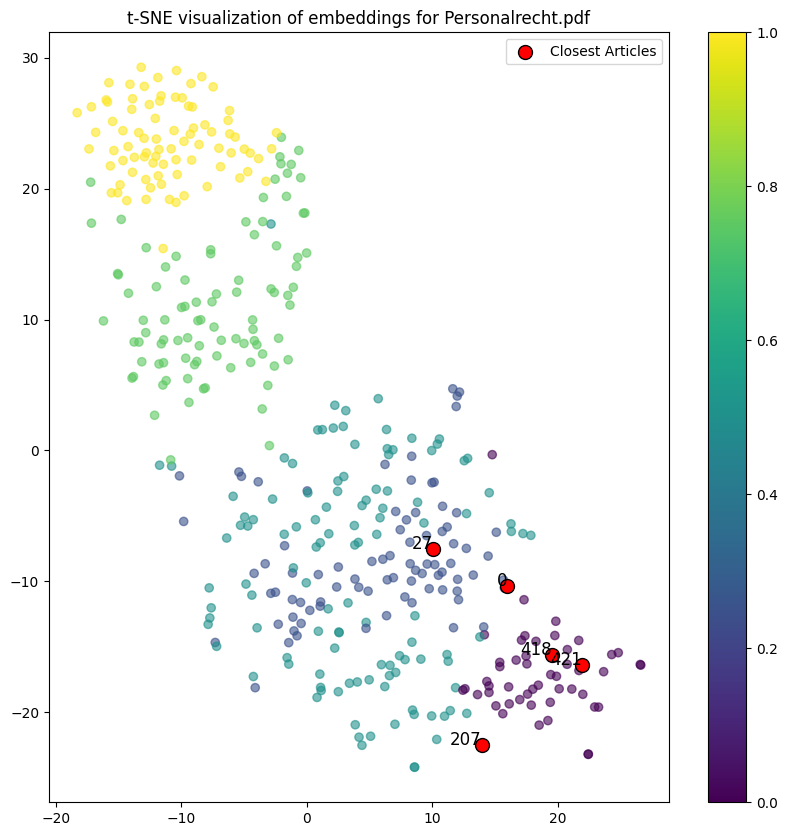

Chunk ID: 421, Content: 62 89, 91, 92 
Treueprämie: Berechnung 13, 62 88, 91, 191 
Treueprämie: Teilprämie  90 
 223 Schlagwort PR Art. AB PR Art. 
Treueurlaub  135 
U   
Überbrückungszuschuss 27  
Übergangsbestimmungen 89 187ff 
Überleitung 89 187, 188 
Überstunden → siehe Überzeit   
Überwachung  55 
Überzeit: Barvergütung von 
Mahlzeiten  109 
Überzeit: Grundsätze  162, 167, 
173 
Überzeit: pauschale bzw.  beschränkte Abgeltung  174, 175 
Überzeit: Zuständigkeit 58, 81 174 
Umschulung  38 
Unbezahlter Urlaub:  
Arbeitgeberleistungen  138 
Unbezahlter Urlaub: Gründe  134, 135, 
136 
Unbezahlter Urlaub: Grundsätze  127, 128 
Unbezahlter Urlaub:  Lohnkürzung, Ferienkürzung  75, 117 
Unbezahlter Urlaub:  
Zuständigkeit 70 23, 24, 40, 
137 
Unfall → siehe Krankheit   
Unfallversicherung  
→ siehe auch Versicherungen 86  
Unfallversicherung:  
Arbeitgeberleistungen 86 138 
224 Schlagwort PR Art. AB PR Art. 
Unfallversicherung: Wegfall  
Versicherungsschutz  87 
Unterstützungszulagen  126 

In [14]:
import os
import json
import faiss
import numpy as np
import PyPDF2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

def split_pdf_to_text_chunks(pdf_path, chunk_size=1000):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text() + "\n"
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    return chunks

def create_embeddings(text_chunks, model):
    return model.encode(text_chunks)

def build_faiss_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

def similarity_search(index, query_embedding, k=5):
    query_embedding = np.array(query_embedding).astype('float32')
    if query_embedding.ndim == 1:
        query_embedding = np.expand_dims(query_embedding, axis=0)
    D, I = index.search(query_embedding, k)
    return I[0], D[0]

def visualize_retrieval(embeddings, neighbors, dataset_name):
    similarity_matrix = cosine_similarity(embeddings)
    kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
    labels = kmeans.labels_
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    closest_points = embeddings_2d[neighbors]
    plt.scatter(closest_points[:, 0], closest_points[:, 1], c='red', edgecolors='k', s=100, label='Closest Articles')
    for i, (x, y) in enumerate(closest_points):
        plt.text(x, y, str(neighbors[i]), fontsize=12, ha='right')
    plt.colorbar()
    plt.title(f"t-SNE visualization of embeddings for {dataset_name}")
    plt.legend()
    plt.show()

def evaluate_model(pdf_path, query, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    text_chunks = split_pdf_to_text_chunks(pdf_path)
    embeddings = create_embeddings(text_chunks, model)
    index = build_faiss_index(np.array(embeddings))
    query_embedding = model.encode([query])
    
    print(f"Query embedding shape: {query_embedding.shape}")
    print(f"Embeddings shape: {embeddings.shape}")
    
    neighbors, distances = similarity_search(index, query_embedding)
    visualize_retrieval(np.array(embeddings), neighbors, os.path.basename(pdf_path))
    for idx in neighbors:
        print(f"Chunk ID: {idx}, Content: {text_chunks[idx]}")

# Example usage
evaluate_model('../sample_data/Personalrecht.pdf', 'Was sind Nachtzulagen?')

